In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

In [2]:
data_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Training and Validation')
test_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Testing')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1520


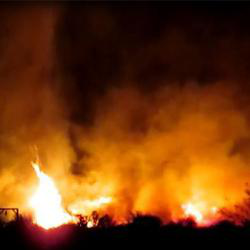

In [4]:
fire = list(data_dir.glob('fire/*'))
img = PIL.Image.open(str(fire[0]))
display(img)

### Load data into a tf dataset

In [5]:
batch_size = 32
img_height = 160
img_width = 160

# Validation split 80/20

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

Found 1520 files belonging to 2 classes.
Using 1216 files for training.


2022-03-18 14:44:30.041564: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-18 14:44:30.042012: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-18 14:44:30.044641: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size    
    )


Found 1520 files belonging to 2 classes.
Using 304 files for validation.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

Found 380 files belonging to 2 classes.


### Get Class Names

In [8]:
class_names = train_ds.class_names
print(class_names)

['fire', 'nofire']


### Visualise Data

2022-03-18 14:44:34.750951: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-18 14:44:34.770748: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3193965000 Hz


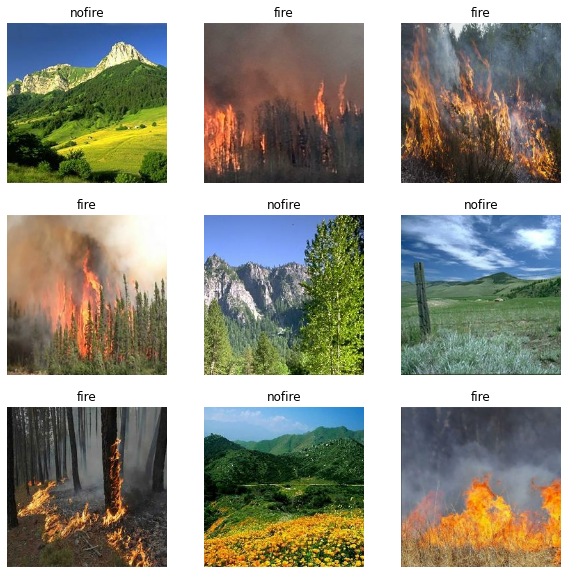

In [9]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

### Create the base model from pre-trained convnets

In [11]:
## By specifying "include_top=False" argument you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction

IMG_SHAPE = (img_width, img_height) + (3,)
# base_model = tf.keras.applications.EfficientNetB4(input_shape = IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')

base_model = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
    classifier_activation="softmax",
)


image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


71688192/71686520 [==============================] - 2s 0us/step
(32, 5, 5, 1792)


## Feature Extraction

In [12]:
base_model.trainable = False
base_model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 160, 160, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 160, 160, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 161, 161, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

block6f_expand_bn (BatchNormali (None, 5, 5, 1632)   6528        block6f_expand_conv[0][0]        
__________________________________________________________________________________________________
block6f_expand_activation (Acti (None, 5, 5, 1632)   0           block6f_expand_bn[0][0]          
__________________________________________________________________________________________________
block6f_dwconv (DepthwiseConv2D (None, 5, 5, 1632)   40800       block6f_expand_activation[0][0]  
__________________________________________________________________________________________________
block6f_bn (BatchNormalization) (None, 5, 5, 1632)   6528        block6f_dwconv[0][0]             
__________________________________________________________________________________________________
block6f_activation (Activation) (None, 5, 5, 1632)   0           block6f_bn[0][0]                 
__________________________________________________________________________________________________
block6f_se

## Add classification head

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [14]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


### Chain together the model

In [15]:
inputs = tf.keras.Input(shape = (160, 160, 3))
x = base_model(inputs, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [62]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=(True)),
              metrics = ['accuracy'])

In [63]:

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 5, 5, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


## Train the model

In [64]:
# Tests the initial base model
initial_epochs = 10
loss0, accuracy0 = model.evaluate(val_ds)

10/10 [==============================] - 17s 988ms/step - loss: 0.7089 - accuracy: 0.5676


In [65]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.72
initial accuracy: 0.52


In [66]:
history = model.fit(train_ds,
                    epochs = initial_epochs,
                    validation_data = val_ds)

Epoch 1/10
38/38 [==============================] - 58s 1s/step - loss: 0.6785 - accuracy: 0.5214 - val_loss: 0.6262 - val_accuracy: 0.5230
Epoch 2/10
38/38 [==============================] - 47s 1s/step - loss: 0.5926 - accuracy: 0.5765 - val_loss: 0.5484 - val_accuracy: 0.5592
Epoch 3/10
38/38 [==============================] - 48s 1s/step - loss: 0.5206 - accuracy: 0.6332 - val_loss: 0.4842 - val_accuracy: 0.6678
Epoch 4/10
38/38 [==============================] - 49s 1s/step - loss: 0.4632 - accuracy: 0.7122 - val_loss: 0.4311 - val_accuracy: 0.7566
Epoch 5/10
38/38 [==============================] - 49s 1s/step - loss: 0.4177 - accuracy: 0.7829 - val_loss: 0.3862 - val_accuracy: 0.8191
Epoch 6/10
38/38 [==============================] - 48s 1s/step - loss: 0.3735 - accuracy: 0.8553 - val_loss: 0.3488 - val_accuracy: 0.8849
Epoch 7/10
38/38 [==============================] - 49s 1s/step - loss: 0.3422 - accuracy: 0.8947 - val_loss: 0.3175 - val_accuracy: 0.9079
Epoch 8/10
38/38 [==

### Learning Curves

Found 380 files belonging to 2 classes.


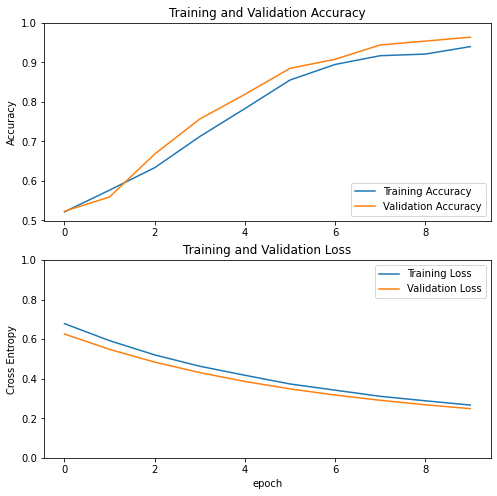

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Fine Tuning

In [16]:
# Previously the base model weights were not updated and only a few layers on top of the EfficientNetB4was trained
# Unfreeze and train the top layers of the pre-trained model to fine tune to the dataset

## Un-freeze top layers of the model

base_model.trainable = True

In [69]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  237


In [80]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compile the Model

In [81]:
## Important to use a lower training weight since using more layers, otherwise
# it could overfit very quickly 

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = ['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 5, 5, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 3,841,629
Non-trainable params: 209,223
_________________________________________________________________


In [82]:
print(len(model.trainable_variables))


125


### Continue Training the Model

In [83]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = val_ds)


Epoch 10/20
38/38 [==============================] - 159s 3s/step - loss: 0.1986 - accuracy: 0.9532 - val_loss: 0.0942 - val_accuracy: 0.9868
Epoch 11/20
38/38 [==============================] - 123s 3s/step - loss: 0.0785 - accuracy: 0.9885 - val_loss: 0.0540 - val_accuracy: 0.9901
Epoch 12/20
38/38 [==============================] - 126s 3s/step - loss: 0.0370 - accuracy: 0.9924 - val_loss: 0.0397 - val_accuracy: 0.9901
Epoch 13/20
38/38 [==============================] - 134s 4s/step - loss: 0.0184 - accuracy: 0.9982 - val_loss: 0.0373 - val_accuracy: 0.9901
Epoch 14/20
38/38 [==============================] - 125s 3s/step - loss: 0.0122 - accuracy: 0.9978 - val_loss: 0.0359 - val_accuracy: 0.9901
Epoch 15/20
38/38 [==============================] - 119s 3s/step - loss: 0.0102 - accuracy: 0.9976 - val_loss: 0.0375 - val_accuracy: 0.9901
Epoch 16/20
38/38 [==============================] - 119s 3s/step - loss: 0.0062 - accuracy: 0.9978 - val_loss: 0.0399 - val_accuracy: 0.9901
Epoch 

### Learning Curves

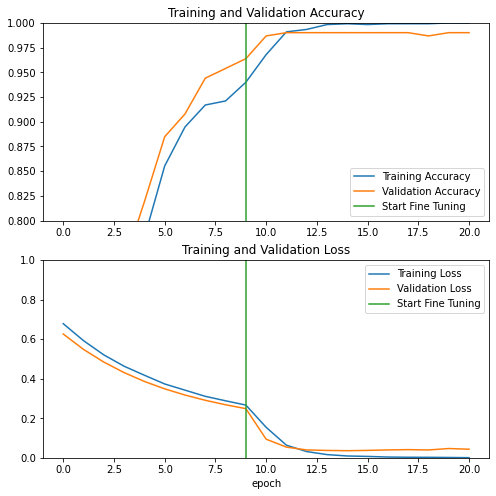

In [84]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [85]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )


test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

Found 380 files belonging to 2 classes.


## Verifying on test set

In [86]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

12/12 [==============================] - 14s 1s/step - loss: 0.0439 - accuracy: 0.9842
Test accuracy : 0.9842105507850647


Predictions:
 [1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0]
Labels:
 [1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0]


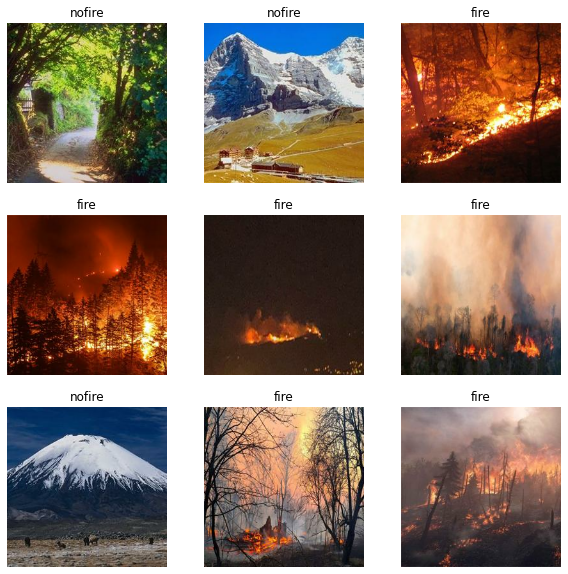

In [87]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# pred = model.predict(test_ds)
# pred = np.argmax(pred, axis = 1)[:5]
# label = 

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

### Confusion Matrix

In [88]:
import pandas as pd
con_mat = tf.math.confusion_matrix(labels = label_batch, predictions=predictions).numpy()
con_mat_norm = np.around(con_mat.astype('float')/con_mat.sum(axis = 1)[:, np.newaxis], decimals = 2)

#con_mat_df = pd.DataFrame(con_mat_norm,
con_mat_df = pd.DataFrame(con_mat,
                          index = class_names,
                          columns = class_names)


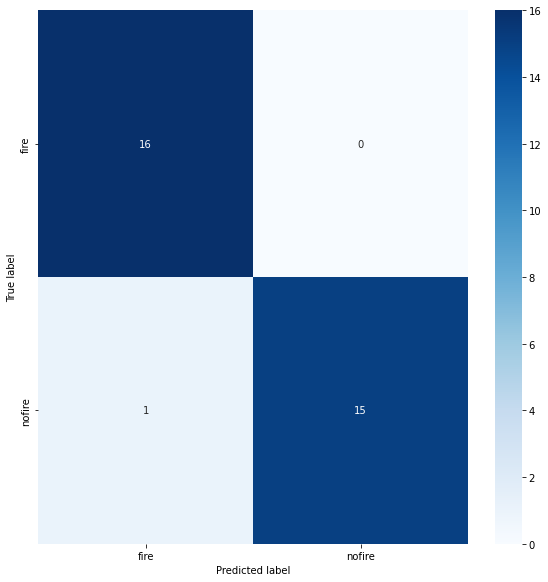

In [89]:
import seaborn as sns
figure = plt.figure(figsize = (8, 8))
sns.heatmap(con_mat_df, annot = True, cmap = plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()